In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.adapt import MLkNN
from sklearn.metrics import hamming_loss, accuracy_score
import string 

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

from nltk.tokenize import word_tokenize



1) Split the full dataset into 0.9 train, 0.1 validation. 0.1 validation is all labelled. <br>
2) The 0.9 train is split into 0.2 labelled, 0.8 unlabelled data. <br>
3) Create a vectorizer (I am using tf-idf) for x value of labeled train, test and unlabeled training datasets<br>
4) Build model from labelled train and label the unlabeled training datasets. Measure for F1 scores. <br>
5) As multilabel/multiclass will output multiple probabilities, only models that have a result higher than the threshold can be accepted. <br>
6) Concatting train labeled data with prediction of unlabeled that have probability > 0.74 (threshold based on journal). This new pseudo-labelled data will be added to the train labelled data, and a second model (will keep to the same classifier) will be run from the new train data sets. <br>
7)Use the second model to predict the remaining of unlabeled data, then iterate step 3 until there are no probability of predicted pseudo-labelled>0.74


In [2]:
#this 0.2/0.8 split is not a hard criteria


In [3]:
df_train_labelled = pd.read_csv('train_labelled_sample.csv')
df_validation_labelled = pd.read_csv('validation_labelled_sample.csv')
df_test_sample = pd.read_csv('df_test_sample.csv')

In [4]:
df_train_labelled

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,518d1baa4ee62c06,"""@Josh3580 of course you are going to oppose i...",0,0,0,0,0,0
1,4682125b685509da,"Copyright Violations\nZhangshou: By now, you ...",0,0,0,0,0,0
2,573c6e9dd5614ade,"Edit request from 120.63.15.134, 29 August 201...",0,0,0,0,0,0
3,7470c1caba22935e,"""I'm around again... Thanks for the comments M...",0,0,0,0,0,0
4,8a24aab08fd0abef,", as you did at Meagan Good, you may be blocke...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
995,1add881f75c8b51b,"Looks like instead of black choppers, your see...",0,0,0,0,0,0
996,9a3ad8998d4ce52b,"""\n\n BLACK DAHLIA MURDER IS NOT 'MELODIC DEAT...",1,0,1,0,1,0
997,f861da2322f1f9db,"""\n\n Rugby \n\nHey, I saw your contribution t...",0,0,0,0,0,0
998,9bfb9305ea9c4293,"Not that it matters, because thanks to Moriori...",0,0,0,0,0,0


In [5]:
df_train_labelled.apply(lambda x: np.array([x['toxic'], x['severe_toxic'], x['obscene'], x['threat'],x['insult'], x['identity_hate']]), axis = 1)

0      [0, 0, 0, 0, 0, 0]
1      [0, 0, 0, 0, 0, 0]
2      [0, 0, 0, 0, 0, 0]
3      [0, 0, 0, 0, 0, 0]
4      [0, 0, 0, 0, 0, 0]
              ...        
995    [0, 0, 0, 0, 0, 0]
996    [1, 0, 1, 0, 1, 0]
997    [0, 0, 0, 0, 0, 0]
998    [0, 0, 0, 0, 0, 0]
999    [0, 0, 0, 0, 0, 0]
Length: 1000, dtype: object

In [6]:
df_train_labelled['target'] = df_train_labelled.apply(lambda x:[x['toxic'], x['severe_toxic'], x['obscene'], x['threat'],x['insult'], x['identity_hate']], axis = 1)
df_train_labelled = df_train_labelled.drop(['toxic','severe_toxic','obscene','threat','insult', 'identity_hate'], axis = 1)
df_train_labelled

,id,comment_text,target
0,518d1baa4ee62c06,"""@Josh3580 of course you are going to oppose i...","[0, 0, 0, 0, 0, 0]"
1,4682125b685509da,"Copyright Violations\nZhangshou: By now, you ...","[0, 0, 0, 0, 0, 0]"
2,573c6e9dd5614ade,"Edit request from 120.63.15.134, 29 August 201...","[0, 0, 0, 0, 0, 0]"
3,7470c1caba22935e,"""I'm around again... Thanks for the comments M...","[0, 0, 0, 0, 0, 0]"
4,8a24aab08fd0abef,", as you did at Meagan Good, you may be blocke...","[0, 0, 0, 0, 0, 0]"
...,...,...,...
995,1add881f75c8b51b,"Looks like instead of black choppers, your see...","[0, 0, 0, 0, 0, 0]"
996,9a3ad8998d4ce52b,"""\n\n BLACK DAHLIA MURDER IS NOT 'MELODIC DEAT...","[1, 0, 1, 0, 1, 0]"
997,f861da2322f1f9db,"""\n\n Rugby \n\nHey, I saw your contribution t...","[0, 0, 0, 0, 0, 0]"
998,9bfb9305ea9c4293,"Not that it matters, because thanks to Moriori...","[0, 0, 0, 0, 0, 0]"


In [7]:
df_test_sample

,id,comment_text
0,2d8fbd7002d1bbde,Thank you for experimenting with the page Drif...
1,5c547ec9e6d8e14d,:: You have added no useful information to Per...
2,1d372ff0a1da78a4,"*Oppose - Romanisation requires FK, not FC."
3,ac5e86d8efdc7b94,":Cutter, Wisconsin-thank you-"
4,0ae9990eed171c6a,== Armillaria root rot == \n\n I figured I sho...
...,...,...
3995,2080b2eb59ecfe3d,""" \n\n == Pheonix V. == \n\n You're welcome. I..."
3996,5b4d04460d5b8773,== Insertion of penis into a pig's mouth == \n...
3997,56495fd916ec5a89,""" \n\n == The history?! == \n\n Who wrote that..."
3998,7ca8e71434a0c6b6,==Categories for discussion nomination of Cate...


In [8]:
df_validation_labelled['target'] = df_validation_labelled.apply(lambda x: [x['toxic'], x['severe_toxic'], x['obscene'], x['threat'],x['insult'], x['identity_hate']], axis = 1)
df_validation_labelled = df_validation_labelled.drop(['toxic','severe_toxic','obscene','threat','insult', 'identity_hate'], axis = 1)
df_validation_labelled

,id,comment_text,target
0,1ffccb4076cbbac7,"""\n\n You have no idea... \n\n...how honored I...","[0, 0, 0, 0, 0, 0]"
1,a36cc13a4c351525,"By definition, there is no paraphiliac flirting.","[0, 0, 0, 0, 0, 0]"
2,3321525528be3a31,"""\n\nBelow I am pasting an email from a histor...","[0, 0, 0, 0, 0, 0]"
3,4a98b516f7cef0e7,I note that you avoid answering the question c...,"[0, 0, 0, 0, 0, 0]"
4,0639c3b95fa665c7,Private request for admin intervention ) \n\nH...,"[0, 0, 0, 0, 0, 0]"
...,...,...,...
995,43893ddfd1beca02,I'm not one of your students. Talk to me like ...,"[1, 0, 0, 0, 0, 0]"
996,9f803165f5c43ef9,"""\nCall it """"Neighborhoods"""" and have it as a ...","[0, 0, 0, 0, 0, 0]"
997,472d7fc518ef1742,"""\nI try to never block for warring if protect...","[0, 0, 0, 0, 0, 0]"
998,ecb592c762bcfda3,"""\n\n Translating \n\nHi. I don't think there ...","[0, 0, 0, 0, 0, 0]"


# Multilabel classifier 

In [9]:
def training_model(X_train,y_train,vectorizer): 
    pipeline = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2, k=1200)),
                         ('clf', RandomForestClassifier())])
    model = pipeline.fit(X_train, y_train) #only used in the trained data
    return model

def cleaning_data(part_df):
    words = stopwords.words("english")
    part_df['comment_text_cleaned']= part_df['comment_text'].apply(lambda x: word_tokenize(x))
    part_df['comment_text_cleaned']= part_df['comment_text_cleaned'].apply(lambda x: [i for i in x if i not in words])
    part_df['comment_text_cleaned']= part_df['comment_text_cleaned'].apply(lambda x: " ".join([i for i in x if i not in string.punctuation]))
    return part_df

def vectorized_data(part_df):
    vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
    #final_features = vectorizer.fit_transform(part_df['comment_text_cleaned']).toarray()
    return vectorizer

#sublinear_tfbool, default=False
#Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).


In [10]:
cleaned = cleaning_data(df_train_labelled)
#cleaned = cleaning_data(df_train.sample(20000))
cleaned_val = cleaning_data(df_validation_labelled)
#cleaned_val = cleaning_data(df_val.sample(5000))
# you have to clean also the comment_text in unlabelled data
cleaned_unlabelled = cleaning_data(df_test_sample)

In [11]:
# Multilabel binariser
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html

In [12]:
vectorized = vectorized_data(cleaned)
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

X_train = cleaned['comment_text_cleaned']
y_train = cleaned['target'].to_numpy()
mlb.fit_transform(y_train)

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [13]:
y_train = np.vstack(y_train) #array of arrays
y_train

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [14]:
mlb.fit_transform(y_train)

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [15]:
#different formats - to discuss next time.

In [16]:
X_train = cleaned['comment_text_cleaned']
y_train = cleaned['target'].values
y_train = np.vstack(y_train)
X_val = cleaned_val['comment_text_cleaned']
y_val = cleaned_val['target'].values
y_val = np.vstack(y_val)
vectorizer = vectorized
trained_model = training_model(X_train,y_train,vectorizer)

In [17]:
#total features
doneby = vectorizer.fit(X_train)
doneby.idf_.shape

(2292,)

In [18]:
y_val_pred=trained_model.predict(X_val)
precision_score(y_val,y_val_pred,average = "samples"),recall_score(y_val,y_val_pred,average = "samples")

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.03575, 0.024916666666666663)

In [19]:
X_unlabelled = cleaned_unlabelled['comment_text_cleaned']
y_prob = trained_model.predict_proba(X_unlabelled)
y_prob[0]

#for each label, it is grouped[0.93, 0.07]

array([[0.9       , 0.1       ],
       [0.53      , 0.47      ],
       [0.63751035, 0.36248965],
       ...,
       [0.93466359, 0.06533641],
       [1.        , 0.        ],
       [0.67625031, 0.32374969]])

In [20]:
y_prob[0].shape
#now we have 1 array for each label

(4000, 2)

In [21]:
#To propagate labels for each of the 6 labels independently, then put everything together.

In [22]:
#toxic	severe_toxic	obscene	threat	insult	identity_hate

## Putting it together

In [41]:
#repeats process until no new labels can be added
def define_x_y(cleaned):
    X_train = cleaned['comment_text_cleaned']
    y_train = cleaned['target'].values
    y_train = np.vstack(y_train)
    return (X_train, y_train)

def training_model(X_train,y_train,vectorizer): 
    pipeline = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2, k=1200)),
                         ('clf', RandomForestClassifier())])
    model = pipeline.fit(X_train, y_train) #only used in the trained data
    return model

def training_process(cleaned):
    vectorized = vectorized_data(cleaned)
    vectorizer = vectorized
    X_train, y_train = define_x_y(cleaned)
    return training_model(X_train,y_train,vectorizer)

def train_val_scores(x, y_val, trained_model): 
    y_val_pred=trained_model.predict(x) #transform depending on which type of function you are talking about
    return precision_score(y_val,y_val_pred,average = "weighted"),recall_score(y_val,y_val_pred,average = "weighted")

def label_propagation(threshold,y_prob, cleaned_unlabelled, label):
    cleaned_unlabelled[label]=np.where(y_prob[:,1] > threshold,1, -1) #label does not need to be converted into a string
    cleaned_unlabelled["not_" + str(label)]=np.where(y_prob[:,0] > threshold,0,-1) # need to do str(label) because you need to sum a string with a number
    cleaned_unlabelled[label] = cleaned_unlabelled.apply(lambda x: np.max([x[label], x["not_" + str(label)]]), axis = 1)
    return cleaned_unlabelled.drop(["not_" + str(label)], axis = 1) 

def pseudo_label_creation(threshold, trained_model, cleaned_unlabelled):
    X_unlabelled = cleaned_unlabelled['comment_text_cleaned']
    y_prob = trained_model.predict_proba(X_unlabelled)
    for i in range(len(y_prob)):
        cleaned_unlabelled = label_propagation(threshold, y_prob[i],cleaned_unlabelled, i)
    #print(cleaned_unlabelled.columns)
    pseudo_label_df = cleaned_unlabelled[(cleaned_unlabelled[0] > -1) & 
                                        (cleaned_unlabelled[1] > -1) &
                                        (cleaned_unlabelled[2] > -1) & 
                                        (cleaned_unlabelled[3] > -1) &
                                        (cleaned_unlabelled[4] > -1) & 
                                        (cleaned_unlabelled[5] > -1) 
                                        ]
    remaining_unlabelled_df = cleaned_unlabelled[(cleaned_unlabelled[0] == -1) |
                                        (cleaned_unlabelled[1] == -1) |
                                        (cleaned_unlabelled[2] == -1) | 
                                        (cleaned_unlabelled[3] == -1) |
                                        (cleaned_unlabelled[4] == -1) | 
                                        (cleaned_unlabelled[5] == -1) 
                                        ]
    pseudo_label_df['target'] = pseudo_label_df.apply(lambda x:[x[0], x[1], x[2], x[3], x[4],x[5]], axis = 1)
    remaining_unlabelled_df['target'] = remaining_unlabelled_df.apply(lambda x:[x[0], x[1], x[2], x[3], x[4],x[5]], axis = 1)
    pseudo_label_df = pseudo_label_df.drop([0,1,2,3,4,5], axis = 1)
    remaining_unlabelled_df = remaining_unlabelled_df.drop([0,1,2,3,4,5], axis = 1)
    return pseudo_label_df, remaining_unlabelled_df

In [53]:
df_precision = pd.DataFrame({})
df_recall = pd.DataFrame({})
df_trainingsize = pd.DataFrame({})
thresholds = [0.6,0.7,0.8,0.85,0.9]

In [54]:
import warnings
warnings.filterwarnings("ignore")

for threshold in thresholds:
    size_new_labels = 51
    cleaned = cleaning_data(df_train_labelled)
    cleaned_val = cleaning_data(df_validation_labelled)
    # you have to clean also the comment_text in unlabelled data
    cleaned_unlabelled = cleaning_data(df_test_sample)

    val_precision = []
    val_recall = []
    min_new_labels = 50
    size_training = []
    X_val, y_val = define_x_y(cleaned_val)

    while len(val_precision) < 5:
    #size_new_labels > min_new_labels:
        print(len(cleaned))
        trained_model = training_process(cleaned)
        X_train,y_train = define_x_y(cleaned) 
        p,r = train_val_scores(X_train,y_train, trained_model)
        p,r = train_val_scores(X_val, y_val, trained_model)
        val_precision.append(p)
        val_recall.append(r) 
        #the dataframes on the left are outputs of the function pseudo_label_creation 
        pseudo_label_df, cleaned_unlabelled = pseudo_label_creation(threshold,trained_model,cleaned_unlabelled)
        #pseudo_label_df = pseudo_label_creation(trained_model,cleaned_unlabelled) 
        #print('new_pseudo_labels')
        size_new_labels = len(pseudo_label_df)
        print(size_new_labels)
        size_training.append(len(cleaned))

        #if size_new_labels > min_new_labels:
        cleaned = cleaned.append(pseudo_label_df[['comment_text_cleaned', 'target']], ignore_index = True)
    df_precision[threshold] = val_precision
    df_recall[threshold] = val_recall
    df_trainingsize[threshold] = size_training

1000
3525
4525
358
4883
75
4958
14
4972
8
1000
2909
3909
795
4704
66
4770
57
4827
59
1000
2445
3445
1081
4526
72
4598
27
4625
12
1000
2156
3156
1217
4373
92
4465
35
4500
25
1000
1748
2748
1216
3964
193
4157
92
4249
33


In [55]:
df_precision.head()

,0.60,0.70,0.80,0.85,0.90
0,0.867698,0.848782,0.856511,0.863564,0.872755
1,0.815753,0.815437,0.828587,0.833292,0.818509
2,0.790782,0.803279,0.822713,0.840655,0.816538
3,0.805037,0.802622,0.845769,0.831703,0.836167
4,0.807466,0.781288,0.824730,0.823868,0.826422


<AxesSubplot:>

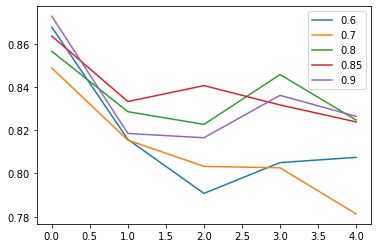

In [56]:
df_precision.plot()

In [57]:
df_recall.head()

,0.60,0.70,0.80,0.85,0.90
0,0.299180,0.319672,0.295082,0.307377,0.286885
1,0.299180,0.282787,0.274590,0.254098,0.262295
2,0.327869,0.356557,0.270492,0.286885,0.270492
3,0.327869,0.352459,0.315574,0.241803,0.266393
4,0.331967,0.381148,0.270492,0.262295,0.286885


<AxesSubplot:>

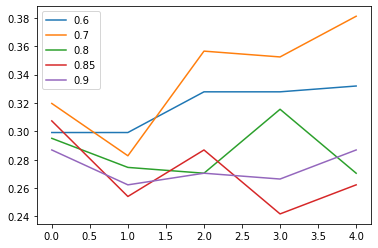

In [58]:
df_recall.plot()

In [59]:
df_trainingsize.head()

,0.60,0.70,0.80,0.85,0.90
0,1000,1000,1000,1000,1000
1,4525,3909,3445,3156,2748
2,4883,4704,4526,4373,3964
3,4958,4770,4598,4465,4157
4,4972,4827,4625,4500,4249


<AxesSubplot:>

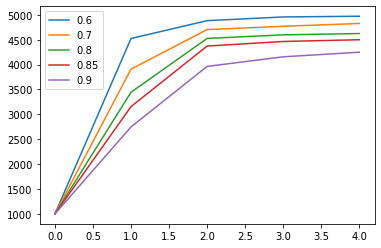

In [60]:
df_trainingsize.plot()

In [ ]:
#by decreasing threshold, increase recall
#small dataset, so limited

In [ ]:
plt.plot(val_precision, label = 'precision')
plt.plot(val_recall, label = 'recall')
plt.legend()

In [ ]:
plt.plot(size_training, val_precision, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Precision')

In [ ]:
#precision went down because you are adding training set data (size), but not quality of training set.

In [ ]:
plt.plot(size_training, val_recall, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Recall')

# Trying hyperparam tuning

In [29]:
#Gridsearch CV for hyperparameter tuning
# no need for scaler = StandardScaler() as we are alr using selectK

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [31]:
def grid_search_model(X_train,y_train,vectorizer): 
    pipeline = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2)),
                         ('clf', RandomForestClassifier())])
    param_grid = {
    "chi__k": [400, 800, 1200, 1600],
    "clf__max_depth": [50, 100],}
    search = GridSearchCV(pipeline, param_grid,cv= 5, n_jobs=2)
    model = search.fit(X_train, y_train)
    return model
    
#training model only fit the model once
#training 40 models, 4x2x5 (5 for the folds)


In [32]:
def training_process_grid_search(cleaned):
    vectorized = vectorized_data(cleaned)
    vectorizer = vectorized
    X_train, y_train = define_x_y(cleaned)
    return grid_search_model(X_train,y_train,vectorizer)

In [36]:
import warnings
warnings.filterwarnings("ignore")

size_new_labels = 51

cleaned = cleaning_data(df_train_labelled)
cleaned_val = cleaning_data(df_validation_labelled)
# you have to clean also the comment_text in unlabelled data
cleaned_unlabelled = cleaning_data(df_test_sample)

val_precision = []
val_recall = []
min_new_labels = 50
size_training = []
X_val, y_val = define_x_y(cleaned_val)

while size_new_labels > min_new_labels:
    print(len(cleaned))
    trained_model = training_process_grid_search(cleaned)
    print("Best parameter (CV score=%0.3f):" % trained_model.best_score_)
    print(trained_model.best_params_)
    X_train,y_train = define_x_y(cleaned) 
    p,r = train_val_scores(X_train,y_train, trained_model)
    p,r = train_val_scores(X_val, y_val, trained_model)
    val_precision.append(p)
    val_recall.append(r)
    #the dataframes on the left are outputs of the function pseudo_label_creation 
    pseudo_label_df, cleaned_unlabelled = pseudo_label_creation(trained_model,cleaned_unlabelled)
    #print('new_pseudo_labels')
    size_new_labels = len(pseudo_label_df)
    print(size_new_labels)
    size_training.append(len(cleaned))
    if size_new_labels > min_new_labels:
        cleaned = cleaned.append(pseudo_label_df[['comment_text_cleaned', 'target']], ignore_index = True)

1000
Best parameter (CV score=0.897):
{'chi__k': 1200, 'clf__max_depth': 50}
3046
4046
Best parameter (CV score=0.973):
{'chi__k': 1200, 'clf__max_depth': 50}
427
4473
Best parameter (CV score=0.976):
{'chi__k': 800, 'clf__max_depth': 50}
68
4541
Best parameter (CV score=0.976):
{'chi__k': 400, 'clf__max_depth': 50}
38


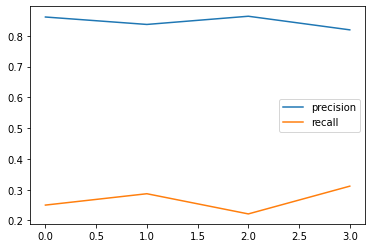

In [37]:
plt.plot(val_precision, label = 'precision')
plt.plot(val_recall, label = 'recall')
plt.legend()

Text(0, 0.5, 'Precision')

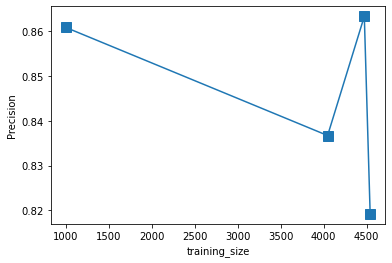

In [38]:
plt.plot(size_training, val_precision, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Precision')

In [39]:
#precision went down because you are adding training set data (size), but not quality of training set.

Text(0, 0.5, 'Recall')

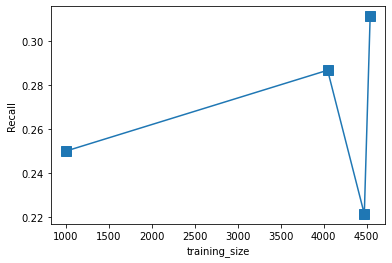

In [40]:
plt.plot(size_training, val_recall, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Recall')